# <p style="text-align: center;"> Projet d'intelligence Artificielle 2023-2024 </p>

### <p style="text-align: center;"> Licence 3 - UFR Mathématique - Informatique</p>

### <p style="text-align: center;"> Réalisé en Binome par : PURSON-PASQUALINI Zoé & WAZNI Zahraa </p>

## 1. Préparation Des Données

### **Questions**

1. **Combien d’attributs comportent ces données ?**

In [13]:
import pandas as pd
import numpy as np
# Chargement du fichier comportant les données

chemin_fichier = 'synthetic.csv'
data = pd.read_csv(chemin_fichier)

# Montrer les 10 premières lignes des données synthetiques
data_head = data.head(5)
# Donne le nombre d'attributs

number_of_attributes = data.shape[1] - 1
print("Les données comportent " + str(number_of_attributes) + " attributs.")

Les données comportent 14 attributs.


2. **En combien de classes différentes les instances sontelles catégorisées ?**

In [17]:
# Donne le nombre de classe
unique_classes = data['Class'].nunique()
print("Nous avons " + str(unique_classes) + " classes uniques.")

Nous avons 4 classes uniques.


3. **Combien d’instances chaque classe compte-elle ?**

In [8]:
# Get the instances count per class
instances_per_class = data['Class'].value_counts().to_dict()
instances_per_class

{1: 908, 0: 674, 2: 472, 3: 244}

4. **Les donnéees sont-elles linéairement séparables ?**


In [12]:
# Fonction pour initialiser les centroides
def initialize_centroids(data, k):
    return data[np.random.choice(data.shape[0], k, replace=False), :]

# fonction pour assigner les clusters
def assign_clusters(data, centroids):
    distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

# fonction pour recalculer les centroides
def recompute_centroids(data, assignments, k):
    new_centroids = np.array([data[assignments == i].mean(axis=0) for i in range(k)])
    return new_centroids

# fonction pour verifier si les centroides  ont converger. 
def centroids_converged(old_centroids, new_centroids):
    return np.all(old_centroids == new_centroids)

# Fonction pour executer le K mean algorithme.
def kmeans(data, k):
    centroids = initialize_centroids(data, k)
    while True:
        old_centroids = centroids
        assignments = assign_clusters(data, centroids)
        centroids = recompute_centroids(data, assignments, k)
        if centroids_converged(old_centroids, centroids):
            break
    return assignments, centroids

# Données sans les étiquettes de classe
data_features = data.drop('Class', axis=1).values

# Ici , on execute K-means avec un K= 4
assignments, centroids = kmeans(data_features, 4)

# Vérification de la pureté des clusters formés
# Création d'une liste d'étiquettes correspondant aux attributions pour vérifier la pureté
assigned_labels = data['Class'].values[np.argsort(assignments)]

# Compter les occurrences de chaque étiquette de classe dans chaque cluster
cluster_labels = {}
for i in range(len(centroids)):
    cluster_labels[i] = np.unique(assigned_labels[assignments == i], return_counts=True)

cluster_labels

{0: (array([0, 1, 2, 3], dtype=int64),
  array([211, 265, 132,  77], dtype=int64)),
 1: (array([0, 1, 2, 3], dtype=int64),
  array([201, 278, 137,  71], dtype=int64)),
 2: (array([0, 1, 2, 3], dtype=int64),
  array([109, 142,  88,  41], dtype=int64)),
 3: (array([0, 1, 2, 3], dtype=int64),
  array([153, 223, 115,  55], dtype=int64))}

## 2.  Mise en œuvre des modèles


### 2.1 Arbre de décision

Le code Python suivant implémente un arbre de décision. L'objectif est d'entraîner plusieurs arbres avec différentes profondeurs (entre 3 et 8), et évaluer leurs performances en utilisant les métriques qu'on a vu en cours (Recall, Accuracy, Precision et F1-Score). Les meilleurs modèles sont sélectionnés en fonction du score F1, une mesure combinée de la précision et du rappel.

In [26]:
# panda et numpy sont importés plus haut
from sklearn.model_selection import train_test_split

## Définition de la classe DecisionTree pour créer et manipuler des arbres de décision
class DecisionTree:
    def __init__(self, attribute=None, split_value=None, left_branch=None, right_branch=None, prediction=None, is_leaf=False):
        self.attribute = attribute
        self.split_value = split_value
        self.left_branch = left_branch
        self.right_branch = right_branch
        self.prediction = prediction
        self.is_leaf = is_leaf
    
    # Fonction pour retourner le résultat du noeud sous forme de chaîne de caractères
    def node_result(self, spacing=''):
        s = ''
        for v in range(len(self.prediction.values)):
            s += f' Class {self.prediction.index[v]} Count: {self.prediction.values[v]}\n{spacing}'
        return s

# Fonction pour calculer l'entropie d'une colonne cible
def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    return np.sum([(-counts[i] / np.sum(counts)) * np.log2(counts[i] / np.sum(counts)) for i in range(len(elements))])

# Fonction pour trouver la meilleure division en utilisant les quartiles des attributs
def best_split_using_quartiles(data, attributes, target_name):
    total_entropy = entropy(data[target_name])
    best_attribute = None
    best_quartile_value = None
    best_ig = 0
    best_partitions = None
    
    for attr in attributes:
        quartiles = data[attr].quantile([0.25, 0.5, 0.75]).values
        for q in quartiles:
            data_below = data[data[attr] <= q]
            data_above = data[data[attr] > q]
            below_entropy = entropy(data_below[target_name])
            above_entropy = entropy(data_above[target_name])
            weighted_entropy = ((len(data_below) / len(data)) * below_entropy) + ((len(data_above) / len(data)) * above_entropy)
            ig = total_entropy - weighted_entropy
            if ig > best_ig:
                best_ig = ig
                best_attribute = attr
                best_quartile_value = q
                best_partitions = (data_below, data_above)
    
    return best_attribute, best_quartile_value, best_partitions

# Fonction pour construire un arbre de décision
def build_tree(data, target_name, attributes, depth, max_depth):
    if depth == max_depth or not attributes or data.empty:
        prediction = data[target_name].value_counts(normalize=True)
        return DecisionTree(prediction=prediction, is_leaf=True)
    
    attribute, split, partitions = best_split_using_quartiles(data, attributes, target_name)
    if not partitions:
        prediction = data[target_name].value_counts(normalize=True)
        return DecisionTree(prediction=prediction, is_leaf=True)
    
    attributes = [attr for attr in attributes if attr != attribute]
    left_branch = build_tree(partitions[0], target_name, attributes, depth+1, max_depth)
    right_branch = build_tree(partitions[1], target_name, attributes, depth+1, max_depth)
    
    return DecisionTree(attribute, split, left_branch, right_branch, data[target_name].value_counts(normalize=True))

# Fonction pour prédire la classe d'une instance en utilisant l'arbre
def predict(tree, instance):
    if tree.is_leaf:
        return tree.prediction.idxmax()
    if instance[tree.attribute] <= tree.split_value:
        return predict(tree.left_branch, instance)
    else:
        return predict(tree.right_branch, instance)

# Fonction pour prédire la classe de toutes les instances dans un ensemble de données
def predict_all(tree, data):
    return data.apply(lambda x: predict(tree, x), axis=1)

# Fonction pour calculer l'exactitude des prédictions
def calculate_accuracy(y_true, y_pred):
    correct = (y_true == y_pred).sum()
    total = len(y_true)
    return correct / total

# Fonction pour calculer la précision, le rappel et le score F1
def calculate_precision_recall_f1(y_true, y_pred):
    unique_classes = np.unique(y_true)
    recall_sum = 0
    precision_sum = 0
    f1_sum = 0
    for class_val in unique_classes:
        true_positives = ((y_pred == class_val) & (y_true == class_val)).sum()
        false_positives = ((y_pred == class_val) & (y_true != class_val)).sum()
        false_negatives = ((y_pred != class_val) & (y_true == class_val)).sum()
        
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        recall_sum += recall
        precision_sum += precision
        f1_sum += f1
    
    # Calcul des moyennes pondérées
    weighted_recall = recall_sum / len(unique_classes)
    weighted_precision = precision_sum / len(unique_classes)
    weighted_f1 = f1_sum / len(unique_classes)
    
    return weighted_precision, weighted_recall, weighted_f1

# Fonction pour évaluer un arbre sur un ensemble de données de test
def evaluate_custom(tree, test_data, target_name):
    y_true = test_data[target_name].values
    y_pred = predict_all(tree, test_data.drop(columns=[target_name])).values
    accuracy = calculate_accuracy(y_true, y_pred)
    precision, recall, f1 = calculate_precision_recall_f1(y_true, y_pred)
    return accuracy, recall, precision, f1

# Chargement et division des données
data = pd.read_csv('synthetic.csv')
target_name = 'Class'
attributes = [col for col in data.columns if col != target_name]
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Entraînement des arbres avec différentes profondeurs et évaluation avec les métriques. 
results = []
for depth in range(3, 9):
    tree = build_tree(train_data, target_name, attributes, 0, depth)
    # print("depth: " + str(depth))
    # print_tree(tree)
    metrics = evaluate_custom(tree, test_data, target_name)
    results.append((depth, metrics))

# Trouver les deux meilleurs modèles basés sur le score F1
sorted_results = sorted(results, key=lambda x: x[1][3], reverse=True)  # Sort by F1-score
best_two_models = sorted_results[:2]

print("Results: ")
for depth, (accuracy, recall, precision, f1) in sorted_results:
    print(f"Depth: {depth}, Accuracy: {accuracy}, Recall: {recall}, Precision: {precision}, F1-score: {f1}")

Results: 
Depth: 7, Accuracy: 0.7782608695652173, Recall: 0.7348929168776778, Precision: 0.7546138473126885, F1-score: 0.743055926277554
Depth: 6, Accuracy: 0.7739130434782608, Recall: 0.7196933138512458, Precision: 0.7469277401342618, F1-score: 0.7293233865735403
Depth: 8, Accuracy: 0.7543478260869565, Recall: 0.6862535514148387, Precision: 0.7193600313873736, F1-score: 0.6982864425538191
Depth: 5, Accuracy: 0.7521739130434782, Recall: 0.6770213383121677, Precision: 0.6990583569471809, F1-score: 0.6821611185244343
Depth: 4, Accuracy: 0.7108695652173913, Recall: 0.6126179660876232, Precision: 0.6626904288006297, F1-score: 0.6174732753658847
Depth: 3, Accuracy: 0.6478260869565218, Recall: 0.5344552366770453, Precision: 0.4736023759608665, F1-score: 0.4992296048768129


On peut déduire que l'arbre avec une profondeur de 7 donne les meilleures performances globales avec un score F1 de 0.743, une exactitude de 0.778, un rappel de 0.735 et une précision de 0.755. Cela suggère que cet arbre a un bon équilibre entre prévenir le surapprentissage et capturer suffisamment de complexité dans les données pour faire des prédictions précises.

### 2.2 Réseaux de neurones artificiels


Epoch 1, Training Loss: 1.4298106711572771, Validation Loss: 1.3538760120287023
Epoch 2, Training Loss: 1.336628522851221, Validation Loss: 1.2732551301929755
Epoch 3, Training Loss: 1.3183981780471712, Validation Loss: 1.263569398674918
Epoch 4, Training Loss: 1.3127450215596612, Validation Loss: 1.259639378500683
Epoch 5, Training Loss: 1.3096199870472949, Validation Loss: 1.2573717211936557
Epoch 6, Training Loss: 1.3076143562816935, Validation Loss: 1.2558546790558507
Epoch 7, Training Loss: 1.3062153367383103, Validation Loss: 1.2547608051130459
Epoch 8, Training Loss: 1.3051836104826036, Validation Loss: 1.2539337932275205
Epoch 9, Training Loss: 1.304391384789731, Validation Loss: 1.2532866583759625
Epoch 10, Training Loss: 1.303764011628859, Validation Loss: 1.2527665848962184
Epoch 11, Training Loss: 1.3032549352318323, Validation Loss: 1.2523395734506964
Epoch 12, Training Loss: 1.3028336125447173, Validation Loss: 1.251982744222175
Epoch 13, Training Loss: 1.30247917571239, 

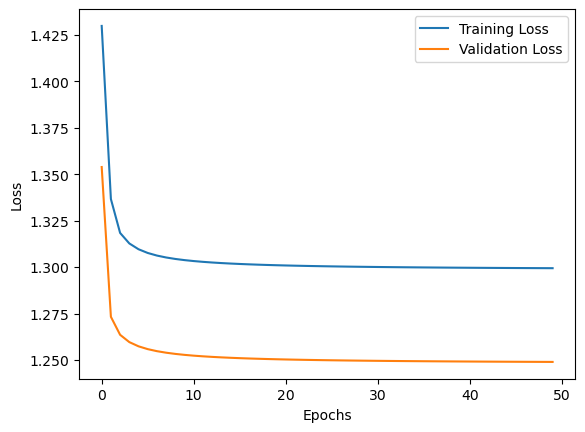

In [33]:
from scipy.special import softmax
from numpy.random import seed

class NeuralNetwork:
    def __init__(self, layer_sizes, activation='relu', learning_rate=0.01, epochs=50, dropout_rate=0.0):
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.dropout_rate = dropout_rate
        self.weights = []
        self.biases = []
        self._initialize_weights()

    def _initialize_weights(self):
        np.random.seed(42)  # for reproducibility
        for i in range(len(self.layer_sizes) - 1):
            limit = np.sqrt(2 / self.layer_sizes[i])  # He initialization for ReLU
            weight = np.random.normal(0, limit, (self.layer_sizes[i+1], self.layer_sizes[i]))
            bias = np.zeros((self.layer_sizes[i+1], 1))
            self.weights.append(weight)
            self.biases.append(bias)
    
    def _forward_prop(self, X):
        A = X
        activations = [A]
        for i in range(len(self.weights)):
            Z = np.dot(self.weights[i], A) + self.biases[i]
            if i < len(self.weights) - 1:
                A = np.tanh(Z) if self.activation == 'tanh' else np.maximum(0, Z)
            else:
                A = softmax(Z, axis=0)
            activations.append(A)
        return activations[-1], activations

    def _backward_prop(self, X, y, activations):
        L = len(self.weights) - 1
        y_one_hot = np.zeros((self.layer_sizes[-1], 1))
        y_one_hot[y, 0] = 1
        delta = activations[-1] - y_one_hot
        deltas = [delta]

        for i in range(L, 0, -1):
            delta = np.dot(self.weights[i].T, delta) * (1 - activations[i]**2 if self.activation == 'tanh' else (activations[i] > 0))
            deltas.insert(0, delta)

        for i in range(L + 1):
            dW = np.dot(deltas[i], activations[i].T)
            db = deltas[i]
            self.weights[i] -= self.learning_rate * dW
            self.biases[i] -= self.learning_rate * db

    def train(self, X_train, y_train, X_val, y_val, patience=10):
        training_losses = []
        validation_losses = []
        best_val_loss = float('inf')
        best_weights = []
        best_biases = []
        epochs_no_improve = 0

        for epoch in range(self.epochs):
            epoch_losses = []
            for i in range(len(X_train)):
                X_i = X_train[i:i+1].T
                y_i = y_train[i]
                output, activations = self._forward_prop(X_i)
                self._backward_prop(X_i, y_i, activations)
                loss = -np.log(output[y_i] + 1e-9)  # Cross-entropy loss
                epoch_losses.append(loss)

            training_loss = np.mean(epoch_losses)
            training_losses.append(training_loss)

            # Calculate validation loss
            val_losses = []
            for i in range(len(X_val)):
                X_i = X_val[i:i+1].T
                y_i = y_val[i]
                output, _ = self._forward_prop(X_i)
                val_loss = -np.log(output[y_i] + 1e-9)
                val_losses.append(val_loss)

            validation_loss = np.mean(val_losses)
            validation_losses.append(validation_loss)

            # Early stopping logic
            if validation_loss < best_val_loss:
                best_val_loss = validation_loss
                best_weights = [w.copy() for w in self.weights]
                best_biases = [b.copy() for b in self.biases]
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                self.weights = best_weights
                self.biases = best_biases
                break

            print(f'Epoch {epoch+1}, Training Loss: {training_loss}, Validation Loss: {validation_loss}')

        return training_losses, validation_losses

# Initialize and train the neural network
nn = NeuralNetwork([X_train.shape[1], 20, 15, 10, 5], activation='relu', learning_rate=0.01, epochs=50, dropout_rate=0.1)
training_losses, validation_losses = nn.train(X_train.to_numpy(), y_train_np, X_val.to_numpy(), y_val_np)

# Plotting the training and validation loss curves
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 3 Analyse des modèles

Voici le code qui nous permet de transformer nos données en matrice de confusion pour chaque modèle. Le code suivant donne l'example de celui du fichier y_pred_NN_tanh_10-8-6.csv.

In [69]:
import pandas as pd
import numpy as np

def load_data(pred_path, test_path):
    pred_path = "y_pred_NN_tanh_10-8-6.csv"
    test_path = "y_test.csv"
    # Load the prediction probabilities and actual labels
    y_pred_probs = pd.read_csv(pred_path, header=None)
    y_test = pd.read_csv(test_path, header=None)
    return y_pred_probs, y_test

def construct_confusion_matrix(y_pred_probs, y_test):
    # Convert probabilities to class predictions
    y_pred = y_pred_probs.idxmax(axis=1)
    
    # Number of classes
    num_classes = len(y_pred_probs.columns)
    
    # Create an empty confusion matrix
    cm = np.zeros((num_classes, num_classes), dtype=int)
    
    # Populate the confusion matrix
    for true_class, pred_class in zip(y_test[0], y_pred):
        cm[true_class][pred_class] += 1
    
    return cm

# Paths to the files
pred_path = 'predictions/y_pred_NN_tanh_10-8-6.csv'
test_path = 'predictions/y_test.csv'

# Load data
y_pred_probs, y_test = load_data(pred_path, test_path)

# Construct the confusion matrix
confusion_matrix = construct_confusion_matrix(y_pred_probs, y_test)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix)


Confusion Matrix:
[[144   5   1   6]
 [  0 162   2   2]
 [  3   4  81   1]
 [  2  10   5  32]]


A travers notre matrice de confusion, nous pouvons désormais l'utiliser pour calculer les métriques tel que le recall, accuracy, precision et le F1-score. Le code qui nous aide a faire cela est le suivant : 

In [66]:
def calculate_metrics(cm):
    num_classes = cm.shape[0]
    accuracy = np.trace(cm) / np.sum(cm)
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)

    for i in range(num_classes):
        tp = cm[i, i]  # True Positive
        fp = np.sum(cm[:, i]) - tp  # False Positive
        fn = np.sum(cm[i, :]) - tp  # False Negative

        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
        if (precision[i] + recall[i]) > 0:
            f1_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])
        else:
            f1_score[i] = 0

    return accuracy, precision, recall, f1_score

In [67]:
# Example avec le model y_pred_NN_tanh_10-8-6 :
cm_example = confusion_matrix

accuracy, precision, recall, f1_score = calculate_metrics(cm_example)

# Print the metrics for each class
# Print the metrics for each class as percentages
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision per Class:", ["{:.2f}%".format(p * 100) for p in precision])
print("Recall per Class:", ["{:.2f}%".format(r * 100) for r in recall])
print("F1-Score per Class:", ["{:.2f}%".format(f * 100) for f in f1_score])

Accuracy: 83.26%
Precision per Class: ['84.24%', '86.84%', '75.24%', '0.00%']
Recall per Class: ['89.10%', '99.40%', '88.76%', '0.00%']
F1-Score per Class: ['86.60%', '92.70%', '81.44%', '0.00%']


Cette partie la est pour transformer les modèles d'arbres de decisions

In [77]:
import pandas as pd
import numpy as np

def load_data(pred_path, test_path):
    pred_path = "y_pred_DT6.csv"
    test_path = "y_test.csv"
    # Load the prediction labels and actual labels
    y_pred = pd.read_csv(pred_path, header=None)
    y_test = pd.read_csv(test_path, header=None)
    return y_pred, y_test

def construct_confusion_matrix(y_pred, y_test):
    # Identify all unique classes in the actual labels to determine matrix size
    classes = np.unique(y_test)
    num_classes = len(classes)
    class_index = {k: i for i, k in enumerate(classes)}
    
    # Create an empty confusion matrix
    cm = np.zeros((num_classes, num_classes), dtype=int)
    
    # Populate the confusion matrix
    for true_class, pred_class in zip(y_test[0], y_pred[0]):
        cm[class_index[true_class]][class_index[pred_class]] += 1
    
    return cm

# Paths to the files
pred_path = 'predictions/y_pred_DT4.csv'
test_path = 'predictions/y_test.csv'

# Load data
y_pred, y_test = load_data(pred_path, test_path)

# Construct the confusion matrix
confusion_matrix2 = construct_confusion_matrix(y_pred, y_test)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix2)


Confusion Matrix:
[[130  14  10   2]
 [  9 147   3   7]
 [  9   7  71   2]
 [  5   7  11  26]]


In [78]:
#On calculs les métriques pour les models avec l'arbre de désicions ici
# Example avec le model y_pred_DT4.csv :
cm_example = confusion_matrix2

accuracy, precision, recall, f1_score = calculate_metrics(cm_example)

# Print the metrics for each class
# Print the metrics for each class as percentages
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision per Class:", ["{:.2f}%".format(p * 100) for p in precision])
print("Recall per Class:", ["{:.2f}%".format(r * 100) for r in recall])
print("F1-Score per Class:", ["{:.2f}%".format(f * 100) for f in f1_score])

Accuracy: 81.30%
Precision per Class: ['84.97%', '84.00%', '74.74%', '70.27%']
Recall per Class: ['83.33%', '88.55%', '79.78%', '53.06%']
F1-Score per Class: ['84.14%', '86.22%', '77.17%', '60.47%']
